# Setup

In [1]:
import pandas as pd
import numpy as np

from unicodedata import normalize
from string import punctuation
import re
from scipy.stats import skew
import itertools

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier #Support Vector Machine
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file
from bokeh.models.sources import ColumnDataSource

import seaborn as sns
from __future__ import print_function
import matplotlib.pylab as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Using TensorFlow backend.


# Data Cleaning and Preprocessing

## Import and Clean

In [2]:
length = []
usecols = ['Description (15 Words left - 15 Words right) - 500 Search Window Size','Company name_year','Dummy "tax risk rudimentary"','Dummy "tax risk extensive"','Dummy "tax risk management" (only if Dummy "tax risk" is 1)']
df = pd.read_excel(r'private/data.xlsx')
length.append(len(df)) #original

In [3]:
for col in df.columns[6:20]: #drop all lines where columns 6 to 20 are not empty
    df =df[(df[col].isna())]
length.append(len(df)) #dropped NA 1

df = df[usecols]
df.columns = ['x', 'company','y1', 'y2', 'y3']

df = df.dropna()
length.append(len(df)) #dropped NA 2

df = df[(df['y1']==1) | (df['y1'] == 0) | (df['y1']=='1') | (df['y1'] == '0')]
df = df[(df['y2']==1) | (df['y2'] == 0) | (df['y2']=='1') | (df['y2'] == '0')]
df = df[(df['y3']==1) | (df['y3'] == 0) | (df['y1']=='1') | (df['y1'] == '0')] 

df.x = df.x.astype(str)
df.company = df.company.astype(str)
df.y1 = df.y1.astype(int)
df.y2 = df.y2.astype(int)
df.y3 = df.y3.astype(int)

### Delete rows with x having less than 50 characters

In [4]:
df = df[df['x'].apply(len) >= 50]
# drop short paragraphs
length.append(len(df))

In [5]:
#clean company name
df.company = df.company.apply(lambda x: re.sub(r'[_]\d{4}.*.TXT', '', x)) 
df.company = df.company.apply(lambda x: x.lower())
                     
df = df.reset_index() 
del df['index'] 

### Merge Texts (for y1=1) which are intersecting

In [6]:
def overlap(a, b):
    length = min(len(b),len(a))
    maxindex = max(i for i in range(0,length) if a.endswith(b[:i]))
    return maxindex

In [7]:
i=0
while(i<len(df)-1):
#for i in range(0,len(df[0:10])-1):
    if (df.y1[i] == 0):
        i = i+1
        continue
    o = overlap(df.x[i], df.x[i+1][1:])
    print('\ni =', i)
    print('intersection of ', o, ' characters\n')
    if int(o) > 10:
        print('list[i+1], ', df.x[i+1][0:5])
        df.x[i] += df.x[i+1][o+1:]
        print('Merged: ')#, merged)
        df = df.drop([i+1])
        df = df.reset_index()
        del df['index']
       
    else:
        i = i+1
length.append(len(df)) #dropped intersecting paragraphs


i = 0
intersection of  1  characters


i = 1
intersection of  1  characters


i = 13
intersection of  0  characters


i = 18
intersection of  0  characters


i = 19
intersection of  1  characters


i = 20
intersection of  0  characters


i = 21
intersection of  1  characters


i = 22
intersection of  1  characters


i = 24
intersection of  1  characters


i = 25
intersection of  1  characters


i = 29
intersection of  202  characters

list[i+1],    in 
Merged: 

i = 29
intersection of  542  characters

list[i+1],    suc
Merged: 

i = 29
intersection of  1  characters


i = 30
intersection of  1  characters


i = 31
intersection of  658  characters

list[i+1],    in 
Merged: 

i = 31
intersection of  693  characters

list[i+1],   . Th
Merged: 

i = 31
intersection of  1  characters


i = 32
intersection of  712  characters

list[i+1],   . Th
Merged: 

i = 32
intersection of  0  characters


i = 33
intersection of  710  characters

list[i+1],   . Th
Merged: 

i = 33
intersection of  0  

Merged: 

i = 362
intersection of  357  characters

list[i+1],    rea
Merged: 

i = 362
intersection of  1  characters


i = 395
intersection of  0  characters


i = 396
intersection of  311  characters

list[i+1],    ali
Merged: 

i = 396
intersection of  1  characters


i = 397
intersection of  293  characters

list[i+1],   \x92
Merged: 

i = 397
intersection of  1  characters


i = 398
intersection of  1  characters


i = 400
intersection of  379  characters

list[i+1],   , in
Merged: 

i = 400
intersection of  354  characters

list[i+1],    we 
Merged: 

i = 400
intersection of  1  characters


i = 401
intersection of  408  characters

list[i+1],    Gro
Merged: 

i = 401
intersection of  1  characters


i = 402
intersection of  426  characters

list[i+1],    (an
Merged: 

i = 402
intersection of  0  characters


i = 403
intersection of  291  characters

list[i+1],   \x92
Merged: 

i = 403
intersection of  1  characters


i = 404
intersection of  1  characters


i = 406
intersection


i = 779
intersection of  1  characters


i = 784
intersection of  42  characters

list[i+1],      ,
Merged: 

i = 784
intersection of  1  characters


i = 788
intersection of  1  characters


i = 789
intersection of  1  characters


i = 793
intersection of  0  characters


i = 801
intersection of  1  characters


i = 804
intersection of  1  characters


i = 806
intersection of  1  characters


i = 808
intersection of  1  characters


i = 810
intersection of  1  characters


i = 811
intersection of  1  characters


i = 815
intersection of  1  characters


i = 818
intersection of  1  characters


i = 821
intersection of  1  characters


i = 828
intersection of  244  characters

list[i+1],    to,
Merged: 

i = 828
intersection of  1  characters


i = 835
intersection of  0  characters


i = 836
intersection of  267  characters

list[i+1],    unf
Merged: 

i = 836
intersection of  1  characters


i = 846
intersection of  1  characters


i = 847
intersection of  271  characters

list[i+1],

Merged: 

i = 1068
intersection of  1  characters


i = 1079
intersection of  0  characters


i = 1080
intersection of  100  characters

list[i+1],   Taxa
Merged: 

i = 1080
intersection of  508  characters

list[i+1],   Taxa
Merged: 

i = 1080
intersection of  544  characters

list[i+1],   Taxa
Merged: 

i = 1080
intersection of  1  characters


i = 1089
intersection of  496  characters

list[i+1],    our
Merged: 

i = 1089
intersection of  1  characters


i = 1099
intersection of  728  characters

list[i+1],   , an
Merged: 

i = 1099
intersection of  664  characters

list[i+1],    par
Merged: 

i = 1099
intersection of  710  characters

list[i+1],   , Di
Merged: 

i = 1099
intersection of  723  characters

list[i+1],    Of?
Merged: 

i = 1099
intersection of  1  characters


i = 1101
intersection of  595  characters

list[i+1],    to 
Merged: 

i = 1101
intersection of  610  characters

list[i+1],    ?na
Merged: 

i = 1101
intersection of  1  characters


i = 1108
intersection of  72

Merged: 

i = 1356
intersection of  674  characters

list[i+1],    con
Merged: 

i = 1356
intersection of  617  characters

list[i+1],   , am
Merged: 

i = 1356
intersection of  679  characters

list[i+1],    or 
Merged: 

i = 1356
intersection of  672  characters

list[i+1],    may
Merged: 

i = 1356
intersection of  612  characters

list[i+1],    wor
Merged: 

i = 1356
intersection of  672  characters

list[i+1],    ass
Merged: 

i = 1356
intersection of  1  characters


i = 1357
intersection of  621  characters

list[i+1],    and
Merged: 

i = 1357
intersection of  1  characters


i = 1373
intersection of  1  characters


i = 1386
intersection of  194  characters

list[i+1],   9F\x
Merged: 

i = 1386
intersection of  1  characters


i = 1396
intersection of  0  characters


i = 1408
intersection of  0  characters


i = 1415
intersection of  1  characters


i = 1422
intersection of  351  characters

list[i+1],   )/Op
Merged: 

i = 1422
intersection of  1  characters


i = 1433
inters

Merged: 

i = 1706
intersection of  214  characters

list[i+1],    bet
Merged: 

i = 1706
intersection of  175  characters

list[i+1],    Gro
Merged: 

i = 1706
intersection of  180  characters

list[i+1],    Eur
Merged: 

i = 1706
intersection of  162  characters

list[i+1],    wit
Merged: 

i = 1706
intersection of  161  characters

list[i+1],    als
Merged: 

i = 1706
intersection of  203  characters

list[i+1],    cha
Merged: 

i = 1706
intersection of  199  characters

list[i+1],    of 
Merged: 

i = 1706
intersection of  112  characters

list[i+1],   . It
Merged: 

i = 1706
intersection of  199  characters

list[i+1],    fai
Merged: 

i = 1706
intersection of  237  characters

list[i+1],    req
Merged: 

i = 1706
intersection of  1  characters


i = 1707
intersection of  1  characters


i = 1709
intersection of  0  characters


i = 1710
intersection of  1  characters


i = 1711
intersection of  198  characters

list[i+1],    tak
Merged: 

i = 1711
intersection of  120  characters

Merged: 

i = 1797
intersection of  0  characters


i = 1811
intersection of  228  characters

list[i+1],    whi
Merged: 

i = 1811
intersection of  1  characters


i = 1815
intersection of  345  characters

list[i+1],    of 
Merged: 

i = 1815
intersection of  377  characters

list[i+1],    bus
Merged: 

i = 1815
intersection of  374  characters

list[i+1],    geo
Merged: 

i = 1815
intersection of  1  characters


i = 1818
intersection of  198  characters

list[i+1],      a
Merged: 

i = 1818
intersection of  89  characters

list[i+1],    in 
Merged: 

i = 1818
intersection of  151  characters

list[i+1],    of 
Merged: 

i = 1818
intersection of  1  characters


i = 1821
intersection of  146  characters

list[i+1],   , Te
Merged: 

i = 1821
intersection of  0  characters


i = 1830
intersection of  238  characters

list[i+1],    whi
Merged: 

i = 1830
intersection of  1  characters


i = 1833
intersection of  1  characters


i = 1834
intersection of  209  characters

list[i+1],    C

Merged: 

i = 2298
intersection of  1  characters


i = 2299
intersection of  1  characters


i = 2308
intersection of  227  characters

list[i+1],   )  -
Merged: 

i = 2308
intersection of  1  characters


i = 2310
intersection of  1  characters


i = 2312
intersection of  205  characters

list[i+1],    ded
Merged: 

i = 2312
intersection of  1  characters


i = 2316
intersection of  0  characters


i = 2321
intersection of  1  characters


i = 2323
intersection of  1  characters


i = 2325
intersection of  221  characters

list[i+1],   )  -
Merged: 

i = 2325
intersection of  1  characters


i = 2327
intersection of  1  characters


i = 2332
intersection of  0  characters


i = 2333
intersection of  1  characters


i = 2335
intersection of  1  characters


i = 2337
intersection of  1  characters


i = 2348
intersection of  1  characters


i = 2350
intersection of  1  characters


i = 2352
intersection of  0  characters


i = 2354
intersection of  96  characters

list[i+1],    res
Mer

Merged: 

i = 2834
intersection of  289  characters

list[i+1],    are
Merged: 

i = 2834
intersection of  1  characters


i = 2835
intersection of  412  characters

list[i+1],   6  p
Merged: 

i = 2835
intersection of  363  characters

list[i+1],   94 t
Merged: 

i = 2835
intersection of  1  characters


i = 2855
intersection of  1  characters


i = 2856
intersection of  1  characters


i = 2857
intersection of  331  characters

list[i+1],    app
Merged: 

i = 2857
intersection of  236  characters

list[i+1],    loc
Merged: 

i = 2857
intersection of  376  characters

list[i+1],    in 
Merged: 

i = 2857
intersection of  377  characters

list[i+1],    Dep
Merged: 

i = 2857
intersection of  388  characters

list[i+1],    ove
Merged: 

i = 2857
intersection of  61  characters

list[i+1],    Dep
Merged: 

i = 2857
intersection of  419  characters

list[i+1],    ded
Merged: 

i = 2857
intersection of  1  characters


i = 2858
intersection of  383  characters

list[i+1],    on 
Merged: 




i = 3221
intersection of  1  characters


i = 3230
intersection of  1  characters


i = 3253
intersection of  1  characters


i = 3265
intersection of  0  characters


i = 3269
intersection of  1  characters


i = 3271
intersection of  1  characters


i = 3274
intersection of  1  characters


i = 3275
intersection of  1  characters


i = 3276
intersection of  443  characters

list[i+1],   ) co
Merged: 

i = 3276
intersection of  1  characters


i = 3277
intersection of  345  characters

list[i+1],    on 
Merged: 

i = 3277
intersection of  377  characters

list[i+1],    res
Merged: 

i = 3277
intersection of  437  characters

list[i+1],    pro
Merged: 

i = 3277
intersection of  1  characters


i = 3278
intersection of  0  characters


i = 3280
intersection of  1  characters


i = 3281
intersection of  1  characters


i = 3282
intersection of  0  characters


i = 3284
intersection of  1  characters


i = 3285
intersection of  391  characters

list[i+1],    ter
Merged: 

i = 3285
inter

Merged: 

i = 3756
intersection of  1  characters


i = 3763
intersection of  880  characters

list[i+1],    con
Merged: 

i = 3763
intersection of  1  characters


i = 3770
intersection of  861  characters

list[i+1],    to 
Merged: 

i = 3770
intersection of  454  characters

list[i+1],    in 
Merged: 

i = 3770
intersection of  1  characters


i = 3789
intersection of  733  characters

list[i+1],    Cas
Merged: 

i = 3789
intersection of  854  characters

list[i+1],    Yel
Merged: 

i = 3789
intersection of  874  characters

list[i+1],    nec
Merged: 

i = 3789
intersection of  382  characters

list[i+1],    rec
Merged: 

i = 3789
intersection of  0  characters


i = 3796
intersection of  0  characters


i = 3797
intersection of  693  characters

list[i+1],   ), F
Merged: 

i = 3797
intersection of  848  characters

list[i+1],   ) an
Merged: 

i = 3797
intersection of  872  characters

list[i+1],   8re 
Merged: 

i = 3797
intersection of  512  characters

list[i+1],    ris
Merged: 


Merged: 

i = 4211
intersection of  277  characters

list[i+1],    can
Merged: 

i = 4211
intersection of  346  characters

list[i+1],    bur
Merged: 

i = 4211
intersection of  1  characters


i = 4217
intersection of  1  characters


i = 4218
intersection of  410  characters

list[i+1],    and
Merged: 

i = 4218
intersection of  1  characters


i = 4219
intersection of  412  characters

list[i+1],   . If
Merged: 

i = 4219
intersection of  411  characters

list[i+1],    the
Merged: 

i = 4219
intersection of  1  characters


i = 4220
intersection of  320  characters

list[i+1],    afo
Merged: 

i = 4220
intersection of  375  characters

list[i+1],    the
Merged: 

i = 4220
intersection of  291  characters

list[i+1],    Rep
Merged: 

i = 4220
intersection of  342  characters

list[i+1],   .  F
Merged: 

i = 4220
intersection of  1  characters


i = 4226
intersection of  1  characters


i = 4227
intersection of  415  characters

list[i+1],    in 
Merged: 

i = 4227
intersection of  2 

Merged: 

i = 4975
intersection of  1  characters


i = 4979
intersection of  778  characters

list[i+1],    lea
Merged: 

i = 4979
intersection of  718  characters

list[i+1],    alc
Merged: 

i = 4979
intersection of  672  characters

list[i+1],    mai
Merged: 

i = 4979
intersection of  1  characters


i = 4983
intersection of  778  characters

list[i+1],    lea
Merged: 

i = 4983
intersection of  720  characters

list[i+1],    alc
Merged: 

i = 4983
intersection of  685  characters

list[i+1],    mai
Merged: 

i = 4983
intersection of  0  characters


i = 4987
intersection of  825  characters

list[i+1],    lea
Merged: 

i = 4987
intersection of  753  characters

list[i+1],    alc
Merged: 

i = 4987
intersection of  735  characters

list[i+1],   .   
Merged: 

i = 4987
intersection of  0  characters


i = 5053
intersection of  550  characters

list[i+1],    the
Merged: 

i = 5053
intersection of  1  characters


i = 5055
intersection of  0  characters


i = 5056
intersection of  1 

Merged: 

i = 5794
intersection of  423  characters

list[i+1],    to 
Merged: 

i = 5794
intersection of  364  characters

list[i+1],    res
Merged: 

i = 5794
intersection of  1  characters


i = 5797
intersection of  404  characters

list[i+1],    201
Merged: 

i = 5797
intersection of  428  characters

list[i+1],    a s
Merged: 

i = 5797
intersection of  380  characters

list[i+1],   . Th
Merged: 

i = 5797
intersection of  440  characters

list[i+1],    dif
Merged: 

i = 5797
intersection of  436  characters

list[i+1],   , an
Merged: 

i = 5797
intersection of  1  characters


i = 5802
intersection of  354  characters

list[i+1],    mar
Merged: 

i = 5802
intersection of  403  characters

list[i+1],     si
Merged: 

i = 5802
intersection of  274  characters

list[i+1],    the
Merged: 

i = 5802
intersection of  388  characters

list[i+1],     ta
Merged: 

i = 5802
intersection of  1  characters


i = 5803
intersection of  1  characters


i = 5815
intersection of  0  characters



Merged: 

i = 6139
intersection of  1  characters


i = 6140
intersection of  1  characters


i = 6141
intersection of  1  characters


i = 6144
intersection of  1  characters


i = 6145
intersection of  0  characters


i = 6148
intersection of  1  characters


i = 6149
intersection of  0  characters


i = 6150
intersection of  774  characters

list[i+1],     co
Merged: 

i = 6150
intersection of  0  characters


i = 6153
intersection of  1  characters


i = 6154
intersection of  680  characters

list[i+1],    ove
Merged: 

i = 6154
intersection of  1  characters


i = 6157
intersection of  1  characters


i = 6164
intersection of  1  characters


i = 6165
intersection of  1  characters


i = 6166
intersection of  1  characters


i = 6167
intersection of  0  characters


i = 6169
intersection of  1  characters


i = 6170
intersection of  708  characters

list[i+1],       
Merged: 

i = 6170
intersection of  730  characters

list[i+1],   , co
Merged: 

i = 6170
intersection of  0  chara

Merged: 

i = 6883
intersection of  1  characters


i = 6888
intersection of  0  characters


i = 6892
intersection of  0  characters


i = 6906
intersection of  0  characters


i = 6910
intersection of  0  characters


i = 6918
intersection of  0  characters


i = 6922
intersection of  0  characters


i = 6928
intersection of  1  characters


i = 6929
intersection of  1  characters


i = 6932
intersection of  0  characters


i = 6935
intersection of  1  characters


i = 6937
intersection of  1  characters


i = 6938
intersection of  1  characters


i = 6955
intersection of  1  characters


i = 6956
intersection of  1  characters


i = 6957
intersection of  553  characters

list[i+1],    lev
Merged: 

i = 6957
intersection of  1  characters


i = 6963
intersection of  0  characters


i = 6964
intersection of  1  characters


i = 6965
intersection of  656  characters

list[i+1],    or 
Merged: 

i = 6965
intersection of  638  characters

list[i+1],    the
Merged: 

i = 6965
intersection

Merged: 

i = 7261
intersection of  658  characters

list[i+1],    wil
Merged: 

i = 7261
intersection of  597  characters

list[i+1],   . As
Merged: 

i = 7261
intersection of  64  characters

list[i+1],    Fon
Merged: 

i = 7261
intersection of  0  characters


i = 7265
intersection of  151  characters

list[i+1],   \xE9
Merged: 

i = 7265
intersection of  392  characters

list[i+1],    may
Merged: 

i = 7265
intersection of  1  characters


i = 7266
intersection of  691  characters

list[i+1],    tax
Merged: 

i = 7266
intersection of  639  characters

list[i+1],    the
Merged: 

i = 7266
intersection of  1  characters


i = 7269
intersection of  1  characters


i = 7270
intersection of  661  characters

list[i+1],     Ch
Merged: 

i = 7270
intersection of  612  characters

list[i+1],    the
Merged: 

i = 7270
intersection of  0  characters


i = 7271
intersection of  1  characters


i = 7274
intersection of  1  characters


i = 7276
intersection of  1  characters


i = 7278
interse

Merged: 

i = 7426
intersection of  1  characters


i = 7428
intersection of  698  characters

list[i+1],    Com
Merged: 

i = 7428
intersection of  700  characters

list[i+1],      l
Merged: 

i = 7428
intersection of  558  characters

list[i+1],   , pl
Merged: 

i = 7428
intersection of  0  characters


i = 7429
intersection of  709  characters

list[i+1],   .   
Merged: 

i = 7429
intersection of  696  characters

list[i+1],    res
Merged: 

i = 7429
intersection of  550  characters

list[i+1],      t
Merged: 

i = 7429
intersection of  1  characters


i = 7430
intersection of  1  characters


i = 7431
intersection of  692  characters

list[i+1],   . Fo
Merged: 

i = 7431
intersection of  484  characters

list[i+1],      P
Merged: 

i = 7431
intersection of  669  characters

list[i+1],    law
Merged: 

i = 7431
intersection of  1  characters


i = 7432
intersection of  1  characters


i = 7434
intersection of  1  characters


i = 7435
intersection of  0  characters


i = 7437
inters

Merged: 

i = 7776
intersection of  585  characters

list[i+1],    doc
Merged: 

i = 7776
intersection of  1  characters


i = 7777
intersection of  1  characters


i = 7778
intersection of  1  characters


i = 7779
intersection of  1  characters


i = 7780
intersection of  0  characters


i = 7781
intersection of  1  characters


i = 7782
intersection of  1  characters


i = 7783
intersection of  1  characters


i = 7784
intersection of  1  characters


i = 7789
intersection of  1  characters


i = 7790
intersection of  636  characters

list[i+1],    reg
Merged: 

i = 7790
intersection of  1  characters


i = 7795
intersection of  614  characters

list[i+1],    bud
Merged: 

i = 7795
intersection of  0  characters


i = 7796
intersection of  1  characters


i = 7799
intersection of  651  characters

list[i+1],    pla
Merged: 

i = 7799
intersection of  622  characters

list[i+1],    reg
Merged: 

i = 7799
intersection of  1  characters


i = 7800
intersection of  1  characters


i = 7

Merged: 

i = 7991
intersection of  583  characters

list[i+1],    cor
Merged: 

i = 7991
intersection of  469  characters

list[i+1],    cou
Merged: 

i = 7991
intersection of  611  characters

list[i+1],   -rel
Merged: 

i = 7991
intersection of  544  characters

list[i+1],    ass
Merged: 

i = 7991
intersection of  1  characters


i = 7992
intersection of  5  characters


i = 7993
intersection of  672  characters

list[i+1],    Com
Merged: 

i = 7993
intersection of  584  characters

list[i+1],    cor
Merged: 

i = 7993
intersection of  468  characters

list[i+1],    cou
Merged: 

i = 7993
intersection of  613  characters

list[i+1],   -rel
Merged: 

i = 7993
intersection of  552  characters

list[i+1],     ta
Merged: 

i = 7993
intersection of  1  characters


i = 7994
intersection of  1  characters


i = 7995
intersection of  442  characters

list[i+1],      a
Merged: 

i = 7995
intersection of  632  characters

list[i+1],      G
Merged: 

i = 7995
intersection of  577  characters

Merged: 

i = 8423
intersection of  382  characters

list[i+1],    wit
Merged: 

i = 8423
intersection of  1  characters


i = 8424
intersection of  1  characters


i = 8425
intersection of  342  characters

list[i+1],    the
Merged: 

i = 8425
intersection of  1  characters


i = 8426
intersection of  313  characters

list[i+1],    it 
Merged: 

i = 8426
intersection of  1  characters


i = 8427
intersection of  377  characters

list[i+1],    ris
Merged: 

i = 8427
intersection of  0  characters


i = 8428
intersection of  0  characters


i = 8430
intersection of  424  characters

list[i+1],    sal
Merged: 

i = 8430
intersection of  94  characters

list[i+1],    leg
Merged: 

i = 8430
intersection of  0  characters


i = 8431
intersection of  1  characters


i = 8432
intersection of  410  characters

list[i+1],    mus
Merged: 

i = 8432
intersection of  374  characters

list[i+1],    the
Merged: 

i = 8432
intersection of  194  characters

list[i+1],    cur
Merged: 

i = 8432
interse

Merged: 

i = 9051
intersection of  1  characters


i = 9052
intersection of  0  characters


i = 9054
intersection of  391  characters

list[i+1],    whi
Merged: 

i = 9054
intersection of  1  characters


i = 9056
intersection of  398  characters

list[i+1],    in 
Merged: 

i = 9056
intersection of  1  characters


i = 9058
intersection of  398  characters

list[i+1],    in 
Merged: 

i = 9058
intersection of  1  characters


i = 9060
intersection of  0  characters


i = 9063
intersection of  1  characters


i = 9065
intersection of  1  characters


i = 9067
intersection of  0  characters


i = 9069
intersection of  0  characters


i = 9072
intersection of  0  characters


i = 9077
intersection of  0  characters


i = 9086
intersection of  471  characters

list[i+1],     \x
Merged: 

i = 9086
intersection of  199  characters

list[i+1],    the
Merged: 

i = 9086
intersection of  1  characters


i = 9094
intersection of  1  characters


i = 9095
intersection of  2  characters


i = 9

Merged: 

i = 9417
intersection of  1  characters


i = 9423
intersection of  405  characters

list[i+1],    to 
Merged: 

i = 9423
intersection of  1  characters


i = 9428
intersection of  395  characters

list[i+1],    the
Merged: 

i = 9428
intersection of  1  characters


i = 9436
intersection of  404  characters

list[i+1],    to 
Merged: 

i = 9436
intersection of  1  characters


i = 9439
intersection of  404  characters

list[i+1],    to 
Merged: 

i = 9439
intersection of  1  characters


i = 9444
intersection of  404  characters

list[i+1],    to 
Merged: 

i = 9444
intersection of  0  characters


i = 9447
intersection of  0  characters


i = 9452
intersection of  1  characters


i = 9453
intersection of  0  characters


i = 9455
intersection of  0  characters


i = 9457
intersection of  0  characters


i = 9459
intersection of  1  characters


i = 9462
intersection of  1  characters


i = 9466
intersection of  1  characters


i = 9470
intersection of  1  characters


i = 9

Merged: 

i = 9686
intersection of  1  characters


i = 9688
intersection of  1  characters


i = 9689
intersection of  309  characters

list[i+1],    dam
Merged: 

i = 9689
intersection of  227  characters

list[i+1],    is 
Merged: 

i = 9689
intersection of  263  characters

list[i+1],   /or 
Merged: 

i = 9689
intersection of  1  characters


i = 9690
intersection of  1  characters


i = 9691
intersection of  158  characters

list[i+1],   , IM
Merged: 

i = 9691
intersection of  286  characters

list[i+1],   , re
Merged: 

i = 9691
intersection of  1  characters


i = 9692
intersection of  146  characters

list[i+1],    MOF
Merged: 

i = 9692
intersection of  268  characters

list[i+1],    or 
Merged: 

i = 9692
intersection of  1  characters


i = 9696
intersection of  1  characters


i = 9698
intersection of  0  characters


i = 9718
intersection of  357  characters

list[i+1],   , ap
Merged: 

i = 9718
intersection of  327  characters

list[i+1],    exp
Merged: 

i = 9718
inters

Merged: 

i = 10148
intersection of  324  characters

list[i+1],   .  T
Merged: 

i = 10148
intersection of  1  characters


i = 10149
intersection of  330  characters

list[i+1],    rep
Merged: 

i = 10149
intersection of  272  characters

list[i+1],    Aud
Merged: 

i = 10149
intersection of  420  characters

list[i+1],    Gro
Merged: 

i = 10149
intersection of  1  characters


i = 10150
intersection of  341  characters

list[i+1],    see
Merged: 

i = 10150
intersection of  286  characters

list[i+1],    of 
Merged: 

i = 10150
intersection of  216  characters

list[i+1],    are
Merged: 

i = 10150
intersection of  312  characters

list[i+1],    dif
Merged: 

i = 10150
intersection of  322  characters

list[i+1],    in 
Merged: 

i = 10150
intersection of  346  characters

list[i+1],    of 
Merged: 

i = 10150
intersection of  360  characters

list[i+1],    unc
Merged: 

i = 10150
intersection of  356  characters

list[i+1],   . Pr
Merged: 

i = 10150
intersection of  1  characters

Merged: 

i = 10806
intersection of  1  characters


i = 10807
intersection of  585  characters

list[i+1],    the
Merged: 

i = 10807
intersection of  1  characters


i = 10809
intersection of  600  characters

list[i+1],    use
Merged: 

i = 10809
intersection of  645  characters

list[i+1],    if 
Merged: 

i = 10809
intersection of  618  characters

list[i+1],    is 
Merged: 

i = 10809
intersection of  1  characters


i = 10810
intersection of  574  characters

list[i+1],    the
Merged: 

i = 10810
intersection of  1  characters


i = 10814
intersection of  595  characters

list[i+1],    use
Merged: 

i = 10814
intersection of  641  characters

list[i+1],    if 
Merged: 

i = 10814
intersection of  614  characters

list[i+1],    is 
Merged: 

i = 10814
intersection of  0  characters


i = 10815
intersection of  597  characters

list[i+1],    the
Merged: 

i = 10815
intersection of  1  characters


i = 10816
intersection of  1  characters


i = 10818
intersection of  469  character

Merged: 

i = 11297
intersection of  402  characters

list[i+1],    yea
Merged: 

i = 11297
intersection of  396  characters

list[i+1],    rat
Merged: 

i = 11297
intersection of  278  characters

list[i+1],   96 2
Merged: 

i = 11297
intersection of  302  characters

list[i+1],     Th
Merged: 

i = 11297
intersection of  260  characters

list[i+1],    in 
Merged: 

i = 11297
intersection of  308  characters

list[i+1],    the
Merged: 

i = 11297
intersection of  278  characters

list[i+1],    law
Merged: 

i = 11297
intersection of  1  characters


i = 11302
intersection of  311  characters

list[i+1],     Ki
Merged: 

i = 11302
intersection of  270  characters

list[i+1],    in 
Merged: 

i = 11302
intersection of  306  characters

list[i+1],    tax
Merged: 

i = 11302
intersection of  286  characters

list[i+1],   , ch
Merged: 

i = 11302
intersection of  1  characters


i = 11306
intersection of  444  characters

list[i+1],    the
Merged: 

i = 11306
intersection of  438  characte

Merged: 

i = 11778
intersection of  53  characters

list[i+1],    and
Merged: 

i = 11778
intersection of  0  characters


i = 11780
intersection of  1  characters


i = 11783
intersection of  0  characters


i = 11786
intersection of  0  characters


i = 11790
intersection of  1  characters


i = 11791
intersection of  354  characters

list[i+1],    fis
Merged: 

i = 11791
intersection of  324  characters

list[i+1],    wit
Merged: 

i = 11791
intersection of  1  characters


i = 11796
intersection of  422  characters

list[i+1],    low
Merged: 

i = 11796
intersection of  1  characters


i = 11797
intersection of  412  characters

list[i+1],    des
Merged: 

i = 11797
intersection of  410  characters

list[i+1],    the
Merged: 

i = 11797
intersection of  1  characters


i = 11806
intersection of  405  characters

list[i+1],    man
Merged: 

i = 11806
intersection of  372  characters

list[i+1],    ris
Merged: 

i = 11806
intersection of  391  characters

list[i+1],       
Merged: 


Merged: 

i = 12380
intersection of  1  characters


i = 12381
intersection of  608  characters

list[i+1],   ?ce 
Merged: 

i = 12381
intersection of  533  characters

list[i+1],    wit
Merged: 

i = 12381
intersection of  1  characters


i = 12385
intersection of  630  characters

list[i+1],   . Re
Merged: 

i = 12385
intersection of  563  characters

list[i+1],    lin
Merged: 

i = 12385
intersection of  1  characters


i = 12386
intersection of  616  characters

list[i+1],    lev
Merged: 

i = 12386
intersection of  549  characters

list[i+1],    lev
Merged: 

i = 12386
intersection of  1  characters


i = 12391
intersection of  636  characters

list[i+1],   . Re
Merged: 

i = 12391
intersection of  568  characters

list[i+1],    lin
Merged: 

i = 12391
intersection of  1  characters


i = 12392
intersection of  616  characters

list[i+1],    lev
Merged: 

i = 12392
intersection of  549  characters

list[i+1],    lev
Merged: 

i = 12392
intersection of  1  characters


i = 12396
in

Merged: 

i = 12909
intersection of  1  characters


i = 12915
intersection of  421  characters

list[i+1],    cur
Merged: 

i = 12915
intersection of  1  characters


i = 12918
intersection of  553  characters

list[i+1],    lea
Merged: 

i = 12918
intersection of  535  characters

list[i+1],    ser
Merged: 

i = 12918
intersection of  1  characters


i = 12927
intersection of  543  characters

list[i+1],    lea
Merged: 

i = 12927
intersection of  521  characters

list[i+1],    pur
Merged: 

i = 12927
intersection of  1  characters


i = 12934
intersection of  544  characters

list[i+1],    lin
Merged: 

i = 12934
intersection of  502  characters

list[i+1],    wel
Merged: 

i = 12934
intersection of  1  characters


i = 12942
intersection of  524  characters

list[i+1],    lin
Merged: 

i = 12942
intersection of  488  characters

list[i+1],    wel
Merged: 

i = 12942
intersection of  1  characters


i = 12947
intersection of  559  characters

list[i+1],    pay
Merged: 

i = 12947
in

Merged: 

i = 13808
intersection of  414  characters

list[i+1],   .   
Merged: 

i = 13808
intersection of  127  characters

list[i+1],    inh
Merged: 

i = 13808
intersection of  1  characters


i = 13809
intersection of  1  characters


i = 13812
intersection of  1  characters


i = 13813
intersection of  0  characters


i = 13831
intersection of  1  characters


i = 13863
intersection of  1  characters


i = 13867
intersection of  1  characters


i = 13870
intersection of  1  characters


i = 13873
intersection of  1  characters


i = 13917
intersection of  1  characters


i = 13924
intersection of  1  characters


i = 13928
intersection of  1  characters


i = 13929
intersection of  1  characters


i = 13930
intersection of  1  characters


i = 13931
intersection of  1  characters


i = 13932
intersection of  1  characters


i = 13933
intersection of  1  characters


i = 13936
intersection of  1  characters


i = 13937
intersection of  349  characters

list[i+1],    a r
Merged: 



Merged: 

i = 14358
intersection of  372  characters

list[i+1],    cha
Merged: 

i = 14358
intersection of  325  characters

list[i+1],    to 
Merged: 

i = 14358
intersection of  372  characters

list[i+1],    tha
Merged: 

i = 14358
intersection of  1  characters


i = 14400
intersection of  0  characters


i = 14403
intersection of  643  characters

list[i+1],    pro
Merged: 

i = 14403
intersection of  537  characters

list[i+1],    unc
Merged: 

i = 14403
intersection of  650  characters

list[i+1],    the
Merged: 

i = 14403
intersection of  0  characters


i = 14408
intersection of  687  characters

list[i+1],    tax
Merged: 

i = 14408
intersection of  576  characters

list[i+1],    the
Merged: 

i = 14408
intersection of  1  characters


i = 14409
intersection of  1  characters


i = 14411
intersection of  1  characters


i = 14413
intersection of  635  characters

list[i+1],    tax
Merged: 

i = 14413
intersection of  527  characters

list[i+1],    the
Merged: 

i = 14413
in

Merged: 

i = 14744
intersection of  549  characters

list[i+1],    and
Merged: 

i = 14744
intersection of  516  characters

list[i+1],    of 
Merged: 

i = 14744
intersection of  537  characters

list[i+1],    Chi
Merged: 

i = 14744
intersection of  1  characters


i = 14747
intersection of  581  characters

list[i+1],    all
Merged: 

i = 14747
intersection of  532  characters

list[i+1],    ope
Merged: 

i = 14747
intersection of  482  characters

list[i+1],    pro
Merged: 

i = 14747
intersection of  564  characters

list[i+1],    for
Merged: 

i = 14747
intersection of  536  characters

list[i+1],    pol
Merged: 

i = 14747
intersection of  545  characters

list[i+1],    wit
Merged: 

i = 14747
intersection of  1  characters


i = 14749
intersection of  520  characters

list[i+1],    in 
Merged: 

i = 14749
intersection of  1  characters


i = 14753
intersection of  585  characters

list[i+1],    ove
Merged: 

i = 14753
intersection of  589  characters

list[i+1],    Boa
Merged:

Merged: 

i = 14912
intersection of  430  characters

list[i+1],    has
Merged: 

i = 14912
intersection of  537  characters

list[i+1],    spe
Merged: 

i = 14912
intersection of  1  characters


i = 14915
intersection of  1  characters


i = 14917
intersection of  663  characters

list[i+1],    man
Merged: 

i = 14917
intersection of  513  characters

list[i+1],    rec
Merged: 

i = 14917
intersection of  0  characters


i = 14918
intersection of  686  characters

list[i+1],    Leg
Merged: 

i = 14918
intersection of  538  characters

list[i+1],    to 
Merged: 

i = 14918
intersection of  584  characters

list[i+1],    rep
Merged: 

i = 14918
intersection of  466  characters

list[i+1],    the
Merged: 

i = 14918
intersection of  676  characters

list[i+1],    spe
Merged: 

i = 14918
intersection of  691  characters

list[i+1],    sys
Merged: 

i = 14918
intersection of  0  characters


i = 14920
intersection of  676  characters

list[i+1],   , co
Merged: 

i = 14920
intersection of 

Merged: 

i = 15022
intersection of  1  characters


i = 15026
intersection of  1  characters


i = 15027
intersection of  223  characters

list[i+1],    rec
Merged: 

i = 15027
intersection of  263  characters

list[i+1],    att
Merged: 

i = 15027
intersection of  1  characters


i = 15028
intersection of  0  characters


i = 15030
intersection of  1  characters


i = 15032
intersection of  173  characters

list[i+1],    rem
Merged: 

i = 15032
intersection of  223  characters

list[i+1],    hol
Merged: 

i = 15032
intersection of  218  characters

list[i+1],    AG 
Merged: 

i = 15032
intersection of  1  characters


i = 15033
intersection of  1  characters


i = 15034
intersection of  1  characters


i = 15037
intersection of  1  characters


i = 15038
intersection of  1  characters


i = 15040
intersection of  239  characters

list[i+1],    AG.
Merged: 

i = 15040
intersection of  24  characters

list[i+1],    as 
Merged: 

i = 15040
intersection of  152  characters

list[i+1],   

Merged: 

i = 15440
intersection of  0  characters


i = 15444
intersection of  265  characters

list[i+1],    wit
Merged: 

i = 15444
intersection of  243  characters

list[i+1],    ris
Merged: 

i = 15444
intersection of  263  characters

list[i+1],    suf
Merged: 

i = 15444
intersection of  1  characters


i = 15445
intersection of  255  characters

list[i+1],     va
Merged: 

i = 15445
intersection of  252  characters

list[i+1],    bee
Merged: 

i = 15445
intersection of  1  characters


i = 15446
intersection of  197  characters

list[i+1],    are
Merged: 

i = 15446
intersection of  1  characters


i = 15455
intersection of  1  characters


i = 15456
intersection of  248  characters

list[i+1],    not
Merged: 

i = 15456
intersection of  259  characters

list[i+1],    rel
Merged: 

i = 15456
intersection of  1  characters


i = 15458
intersection of  1  characters


i = 15459
intersection of  248  characters

list[i+1],    not
Merged: 

i = 15459
intersection of  259  character

Merged: 

i = 16044
intersection of  1  characters


i = 16049
intersection of  1  characters


i = 16051
intersection of  0  characters


i = 16052
intersection of  249  characters

list[i+1],   .   
Merged: 

i = 16052
intersection of  1  characters


i = 16058
intersection of  1  characters


i = 16060
intersection of  1  characters


i = 16062
intersection of  1  characters


i = 16064
intersection of  1  characters


i = 16067
intersection of  245  characters

list[i+1],    emp
Merged: 

i = 16067
intersection of  77  characters

list[i+1],    Gro
Merged: 

i = 16067
intersection of  1  characters


i = 16068
intersection of  7  characters


i = 16069
intersection of  0  characters


i = 16070
intersection of  1  characters


i = 16072
intersection of  275  characters

list[i+1],    amo
Merged: 

i = 16072
intersection of  1  characters


i = 16074
intersection of  1  characters


i = 16075
intersection of  1  characters


i = 16076
intersection of  267  characters

list[i+1],    

Merged: 

i = 16226
intersection of  262  characters

list[i+1],   , am
Merged: 

i = 16226
intersection of  1  characters


i = 16230
intersection of  425  characters

list[i+1],    to 
Merged: 

i = 16230
intersection of  1  characters


i = 16237
intersection of  420  characters

list[i+1],      a
Merged: 

i = 16237
intersection of  1  characters


i = 16288
intersection of  393  characters

list[i+1],    bas
Merged: 

i = 16288
intersection of  1  characters


i = 16299
intersection of  0  characters


i = 16300
intersection of  1  characters


i = 16311
intersection of  421  characters

list[i+1],    of 
Merged: 

i = 16311
intersection of  400  characters

list[i+1],    and
Merged: 

i = 16311
intersection of  365  characters

list[i+1],    rev
Merged: 

i = 16311
intersection of  1  characters


i = 16317
intersection of  412  characters

list[i+1],    on 
Merged: 

i = 16317
intersection of  362  characters

list[i+1],    for
Merged: 

i = 16317
intersection of  357  character

Merged: 

i = 16465
intersection of  374  characters

list[i+1],    its
Merged: 

i = 16465
intersection of  369  characters

list[i+1],    cha
Merged: 

i = 16465
intersection of  1  characters


i = 16466
intersection of  1  characters


i = 16467
intersection of  389  characters

list[i+1],     fu
Merged: 

i = 16467
intersection of  390  characters

list[i+1],    bee
Merged: 

i = 16467
intersection of  361  characters

list[i+1],    bas
Merged: 

i = 16467
intersection of  1  characters


i = 16469
intersection of  1  characters


i = 16470
intersection of  1  characters


i = 16471
intersection of  404  characters

list[i+1],    and
Merged: 

i = 16471
intersection of  368  characters

list[i+1],    of 
Merged: 

i = 16471
intersection of  1  characters


i = 16473
intersection of  1  characters


i = 16474
intersection of  1  characters


i = 16475
intersection of  448  characters

list[i+1],    and
Merged: 

i = 16475
intersection of  390  characters

list[i+1],    ris
Merged: 

Merged: 

i = 17113
intersection of  1  characters


i = 17124
intersection of  1  characters


i = 17126
intersection of  608  characters

list[i+1],    dra
Merged: 

i = 17126
intersection of  1  characters


i = 17128
intersection of  0  characters


i = 17132
intersection of  475  characters

list[i+1],   's r
Merged: 

i = 17132
intersection of  1  characters


i = 17133
intersection of  1  characters


i = 17134
intersection of  0  characters


i = 17135
intersection of  1  characters


i = 17136
intersection of  163  characters

list[i+1],    our
Merged: 

i = 17136
intersection of  1  characters


i = 17137
intersection of  431  characters

list[i+1],    in 
Merged: 

i = 17137
intersection of  1  characters


i = 17138
intersection of  163  characters

list[i+1],    our
Merged: 

i = 17138
intersection of  1  characters


i = 17139
intersection of  442  characters

list[i+1],    com
Merged: 

i = 17139
intersection of  1  characters


i = 17140
intersection of  1  characters



Merged: 

i = 17416
intersection of  512  characters

list[i+1],    man
Merged: 

i = 17416
intersection of  462  characters

list[i+1],      c
Merged: 

i = 17416
intersection of  469  characters

list[i+1],    mit
Merged: 

i = 17416
intersection of  483  characters

list[i+1],   \x92
Merged: 

i = 17416
intersection of  448  characters

list[i+1],    APP
Merged: 

i = 17416
intersection of  434  characters

list[i+1],    jur
Merged: 

i = 17416
intersection of  414  characters

list[i+1],    tax
Merged: 

i = 17416
intersection of  455  characters

list[i+1],    int
Merged: 

i = 17416
intersection of  447  characters

list[i+1],    and
Merged: 

i = 17416
intersection of  382  characters

list[i+1],    fai
Merged: 

i = 17416
intersection of  503  characters

list[i+1],   .   
Merged: 

i = 17416
intersection of  539  characters

list[i+1],    ris
Merged: 

i = 17416
intersection of  1  characters


i = 17417
intersection of  1  characters


i = 17418
intersection of  1  characters

Merged: 

i = 17607
intersection of  418  characters

list[i+1],   . SE
Merged: 

i = 17607
intersection of  1  characters


i = 17608
intersection of  1  characters


i = 17609
intersection of  0  characters


i = 17610
intersection of  1  characters


i = 17611
intersection of  1  characters


i = 17672
intersection of  0  characters


i = 17673
intersection of  1  characters


i = 17674
intersection of  571  characters

list[i+1],    on 
Merged: 

i = 17674
intersection of  1  characters


i = 17684
intersection of  0  characters


i = 17685
intersection of  1  characters


i = 17687
intersection of  1  characters


i = 17688
intersection of  1  characters


i = 17690
intersection of  1  characters


i = 17691
intersection of  0  characters


i = 17694
intersection of  1  characters


i = 17695
intersection of  1  characters


i = 17697
intersection of  1  characters


i = 17700
intersection of  1  characters


i = 17703
intersection of  1  characters


i = 17705
intersection of  1 

Merged: 

i = 18266
intersection of  1  characters


i = 18316
intersection of  0  characters


i = 18322
intersection of  1  characters


i = 18324
intersection of  1  characters


i = 18325
intersection of  1  characters


i = 18326
intersection of  1  characters


i = 18327
intersection of  1  characters


i = 18329
intersection of  1  characters


i = 18331
intersection of  1  characters


i = 18333
intersection of  336  characters

list[i+1],    bus
Merged: 

i = 18333
intersection of  1  characters


i = 18334
intersection of  1  characters


i = 18335
intersection of  308  characters

list[i+1],   , in
Merged: 

i = 18335
intersection of  0  characters


i = 18336
intersection of  336  characters

list[i+1],    bus
Merged: 

i = 18336
intersection of  1  characters


i = 18337
intersection of  1  characters


i = 18338
intersection of  309  characters

list[i+1],   , in
Merged: 

i = 18338
intersection of  1  characters


i = 18339
intersection of  394  characters

list[i+1],   

Merged: 

i = 19281
intersection of  0  characters


i = 19283
intersection of  302  characters

list[i+1],    ass
Merged: 

i = 19283
intersection of  298  characters

list[i+1],    lik
Merged: 

i = 19283
intersection of  8  characters


i = 19284
intersection of  284  characters

list[i+1],    rev
Merged: 

i = 19284
intersection of  287  characters

list[i+1],    un-
Merged: 

i = 19284
intersection of  286  characters

list[i+1],     in
Merged: 

i = 19284
intersection of  252  characters

list[i+1],    to 
Merged: 

i = 19284
intersection of  303  characters

list[i+1],    cha
Merged: 

i = 19284
intersection of  1  characters


i = 19287
intersection of  290  characters

list[i+1],    ass
Merged: 

i = 19287
intersection of  280  characters

list[i+1],    be 
Merged: 

i = 19287
intersection of  0  characters


i = 19288
intersection of  1  characters


i = 19289
intersection of  279  characters

list[i+1],    tax
Merged: 

i = 19289
intersection of  272  characters

list[i+1], 

Merged: 

i = 19620
intersection of  1  characters


i = 19734
intersection of  1  characters


i = 19742
intersection of  468  characters

list[i+1],    Tel
Merged: 

i = 19742
intersection of  439  characters

list[i+1],    of 
Merged: 

i = 19742
intersection of  491  characters

list[i+1],    sur
Merged: 

i = 19742
intersection of  490  characters

list[i+1],    ris
Merged: 

i = 19742
intersection of  1  characters


i = 19743
intersection of  1  characters


i = 19747
intersection of  1  characters


i = 19748
intersection of  487  characters

list[i+1],      l
Merged: 

i = 19748
intersection of  466  characters

list[i+1],    a b
Merged: 

i = 19748
intersection of  505  characters

list[i+1],    of 
Merged: 

i = 19748
intersection of  480  characters

list[i+1],    the
Merged: 

i = 19748
intersection of  427  characters

list[i+1],    sub
Merged: 

i = 19748
intersection of  373  characters

list[i+1],    opi
Merged: 

i = 19748
intersection of  485  characters

list[i+1], 

Merged: 

i = 20478
intersection of  1  characters


i = 20479
intersection of  502  characters

list[i+1],    AG 
Merged: 

i = 20479
intersection of  491  characters

list[i+1],    and
Merged: 

i = 20479
intersection of  360  characters

list[i+1],    tre
Merged: 

i = 20479
intersection of  501  characters

list[i+1],    tra
Merged: 

i = 20479
intersection of  1  characters


i = 20485
intersection of  508  characters

list[i+1],   , th
Merged: 

i = 20485
intersection of  512  characters

list[i+1],    ERC
Merged: 

i = 20485
intersection of  1  characters


i = 20500
intersection of  495  characters

list[i+1],    the
Merged: 

i = 20500
intersection of  1  characters


i = 20713
intersection of  1  characters


i = 20744
intersection of  517  characters

list[i+1],    exi
Merged: 

i = 20744
intersection of  471  characters

list[i+1],    of 
Merged: 

i = 20744
intersection of  494  characters

list[i+1],    fin
Merged: 

i = 20744
intersection of  1  characters


i = 20750
in

Merged: 

i = 21191
intersection of  327  characters

list[i+1],    tax
Merged: 

i = 21191
intersection of  1  characters


i = 21194
intersection of  1  characters


i = 21195
intersection of  445  characters

list[i+1],    and
Merged: 

i = 21195
intersection of  432  characters

list[i+1],    reg
Merged: 

i = 21195
intersection of  0  characters


i = 21198
intersection of  0  characters


i = 21199
intersection of  1  characters


i = 21201
intersection of  475  characters

list[i+1],    dev
Merged: 

i = 21201
intersection of  501  characters

list[i+1],   . De
Merged: 

i = 21201
intersection of  486  characters

list[i+1],    ors
Merged: 

i = 21201
intersection of  0  characters


i = 21202
intersection of  1  characters


i = 21211
intersection of  1  characters


i = 21212
intersection of  331  characters

list[i+1],    of 
Merged: 

i = 21212
intersection of  433  characters

list[i+1],    is 
Merged: 

i = 21212
intersection of  1  characters


i = 21213
intersection of  

Merged: 

i = 21725
intersection of  0  characters


i = 21726
intersection of  530  characters

list[i+1],    tes
Merged: 

i = 21726
intersection of  456  characters

list[i+1],    tax
Merged: 

i = 21726
intersection of  228  characters

list[i+1],    add
Merged: 

i = 21726
intersection of  565  characters

list[i+1],    rel
Merged: 

i = 21726
intersection of  1  characters


i = 21728
intersection of  1  characters


i = 21729
intersection of  0  characters


i = 21730
intersection of  1  characters


i = 21731
intersection of  521  characters

list[i+1],    rep
Merged: 

i = 21731
intersection of  0  characters


i = 21732
intersection of  1  characters


i = 21733
intersection of  502  characters

list[i+1],    rep
Merged: 

i = 21733
intersection of  1  characters


i = 21734
intersection of  476  characters

list[i+1],    reg
Merged: 

i = 21734
intersection of  1  characters


i = 21735
intersection of  1  characters


i = 21738
intersection of  519  characters

list[i+1],  

Merged: 

i = 22273
intersection of  1  characters


i = 22274
intersection of  1  characters


i = 22294
intersection of  1  characters


i = 22296
intersection of  629  characters

list[i+1],   ;  p
Merged: 

i = 22296
intersection of  1  characters


i = 22297
intersection of  1  characters


i = 22316
intersection of  777  characters

list[i+1],   ;   
Merged: 

i = 22316
intersection of  0  characters


i = 22317
intersection of  5  characters


i = 22356
intersection of  0  characters


i = 22361
intersection of  1  characters


i = 22362
intersection of  1  characters


i = 22363
intersection of  676  characters

list[i+1],    aud
Merged: 

i = 22363
intersection of  1  characters


i = 22364
intersection of  1  characters


i = 22365
intersection of  1  characters


i = 22375
intersection of  1  characters


i = 22376
intersection of  53  characters

list[i+1],    int
Merged: 

i = 22376
intersection of  1  characters


i = 22377
intersection of  1  characters


i = 22378
inter

i = 22863
intersection of  1  characters


i = 22869
intersection of  594  characters

list[i+1],    pro
Merged: 

i = 22869
intersection of  634  characters

list[i+1],    pra
Merged: 

i = 22869
intersection of  1  characters


i = 22915
intersection of  498  characters

list[i+1],   . Mo
Merged: 

i = 22915
intersection of  404  characters

list[i+1],    by 
Merged: 

i = 22915
intersection of  1  characters


i = 22920
intersection of  507  characters

list[i+1],   . Mo
Merged: 

i = 22920
intersection of  421  characters

list[i+1],    by 
Merged: 

i = 22920
intersection of  0  characters


i = 22927
intersection of  478  characters

list[i+1],    the
Merged: 

i = 22927
intersection of  584  characters

list[i+1],    are
Merged: 

i = 22927
intersection of  434  characters

list[i+1],    tax
Merged: 

i = 22927
intersection of  0  characters


i = 22938
intersection of  498  characters

list[i+1],   . Mo
Merged: 

i = 22938
intersection of  605  characters

list[i+1],     th
Mer

### Compare length of dataframe by cleaning steps

The plot shows that there was a considerable amount of NAs as well as a considerable amount of overlapping paragraphs.

[29281, 26629, 26554, 26479, 23144]


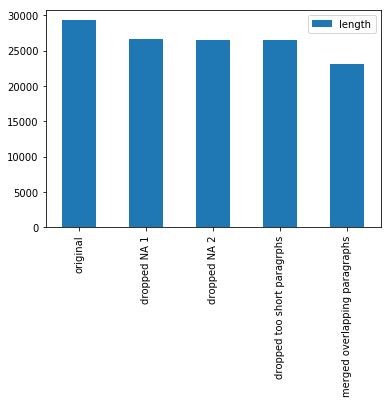

In [8]:
print(length)
steps = ['original', 'dropped NA 1', 'dropped NA 2', 'dropped too short paragrphs', 'merged overlapping paragraphs']
dataframe = pd.DataFrame(
    {'length': length,
     'steps': steps}, 
    index = steps)
dataframe.plot(kind='bar');

## Text Preprocessing

Remove capitalization, punctuation, numbers, stopwords. <br>
Do lemmatization (NLTK) and tokenization. <br>
Unicode errors (produce by converting pdf to txt) are normalized via NFKD.

In [9]:
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = normalize('NFKD', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    
    return text

In [10]:
lemm = WordNetLemmatizer()

In [11]:
df['tokens'] = df['x'].apply(lambda x: " ".join([lemm.lemmatize(w) for w in nltk.word_tokenize(clean_text(x)) if len(w) > 2]))

In [12]:
df.columns = ['x_sentences', 'company', 'y1', 'y2', 'y3', 'x']

## Train/Test Split

Split is done such that companies are either in the train set or the test set. 
No company appears in both sets.

In [13]:
c = int(0.75 * len(df))
c

17358

In [14]:
def get_optimal_split(df,c=0.75):
    i = 0
    while(df.loc[c].company == df.loc[c+i].company):
        i+=1
    return i

In [15]:
c_off = get_optimal_split(df,c)
c_off

124

In [16]:
train_df = df[:c+c_off]
test_df = df[c+c_off:]
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [17]:
train_df.tail()

,x_sentences,company,y1,y2,y3,x
17477,local tax rates reflects the geographical ta...,scor,0,0,0,local tax rate reflects the geographical tax r...
17478,bargain purchase for the acquisitions of Gen...,scor,0,0,0,bargain purchase for the acquisition generali ...
17479,Global Investments ? Information Systems ...,scor,0,0,0,global investment information system strategy ...
17480,. This includes: - A \x91risk driver\x92 ...,scor,0,0,0,this includes xrisk driver system ensuring tha...
17481,below to section 2.6 - Financial Reporting. ...,scor,0,0,0,below section financial reporting group functi...


In [18]:
test_df.head()

,x_sentences,company,y1,y2,y3,x
0,Costs 74 7. Taxation 75 8. Dividends 77 ...,scottish & southern energy,0,0,0,cost taxation dividend earnings per share inta...
1,the pre-tax cash flows of each CGU based on ...,scottish & southern energy,0,0,0,the pre tax cash flow each cgu based past perf...
2,the pre-tax cash flows of each CGU based on ...,scottish & southern energy,0,0,0,the pre tax cash flow each cgu based past perf...
3,being a key customer. In the high risk cate...,scottish & southern energy,1,0,0,being key customer the high risk category long...
4,the pre-tax cash flows of each CGU based on ...,scottish & southern energy,0,0,0,the pre tax cash flow each cgu based past perf...


## Save Datasets

In [19]:
filename = 'private/data_clean.csv'
df.to_csv(filename, index = False)
filename = 'private/train.csv'
train_df.to_csv(filename, index = False)
filename = 'private/test.csv'
test_df.to_csv(filename, index = False)

# Descriptive Statistics

## Information on labels

In [20]:
df = pd.read_csv(r'private/data_clean.csv')

The dataset has 23144 entries.
The plot shows that there is a very low percentage of paragraph labeled as talking about tax risk management (y1=1).


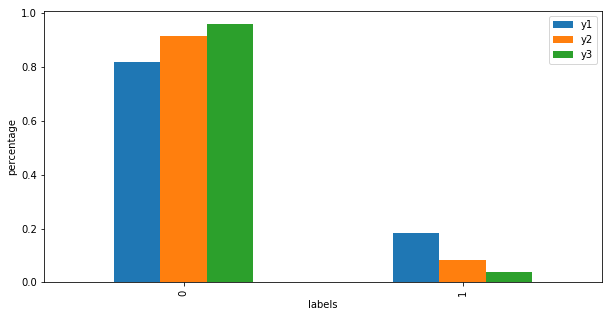

In [21]:
y1_count= df.y1.value_counts(normalize = True)
y2_count= df.y2.value_counts(normalize = True)
y3_count= df.y3.value_counts(normalize = True)

df2 = y1_count.to_frame()
df2['y2'] = y2_count
df2['y3'] = y3_count

print('The dataset has', len(df), 'entries.')
df2.plot.bar(figsize=(10,5))
plt.xlabel('labels')
plt.ylabel('percentage')
print('The plot shows that there is a very low percentage of paragraph labeled as talking about tax risk management (y1=1).')

## Information by company

Out of  570 companies, 136 did not talk about tax risk at all.
The plot shows that most of the labels come from very few companies. Therefore key features learnt might be very company specific.


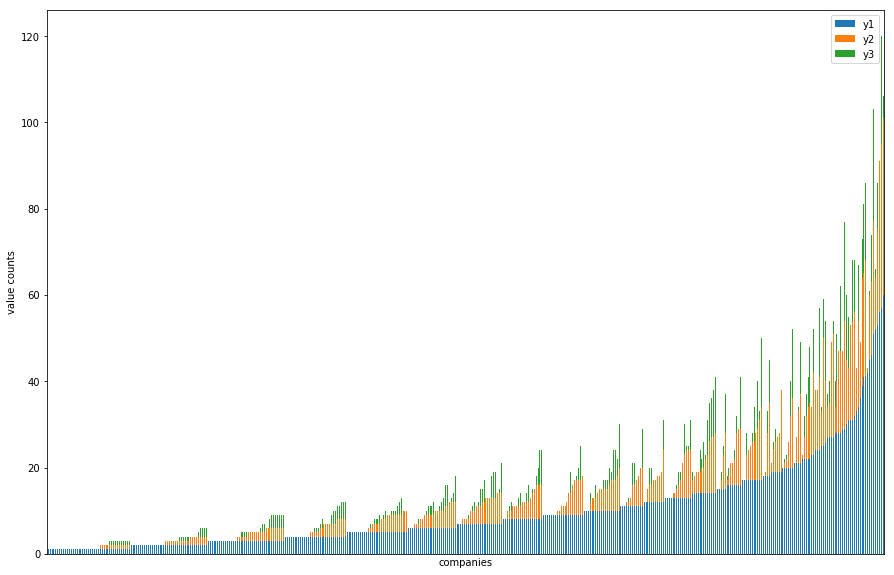

In [22]:
y1_count = df.groupby('company')['y1'].sum()
y2_count = df.groupby("company")['y2'].sum()
y3_count = df.groupby("company")['y3'].sum()

df2 = y1_count.to_frame()
df2['y2'] = y2_count
df2['y3'] = y3_count

df2 = df2.sort_values(['y1', 'y2', 'y3'], ascending=[1, 1, 1]) #sort dataframe
count0 = df2.y1.value_counts() #how many 0
print('Out of ', len(df2), 'companies,', count0[0], 'did not talk about tax risk at all.')
df2 = df2.loc[(df2!=0).any(axis=1)] #drop companies with all 0

#plot
df2.plot.bar(stacked= True, figsize=(15,10))
plt.xticks([])
plt.xlabel('companies')
plt.ylabel('value counts')
print('The plot shows that most of the labels come from very few companies. Therefore key features learnt might be very company specific.')

# Classification

## Baseline Model

### Initialize functions

In [23]:
df = pd.read_csv(r'private/data_clean.csv')
train = pd.read_csv(r'private/train.csv')     
test = pd.read_csv(r'private/test.csv')  

In [24]:
#Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

### Combine 2 different vectorizers with 3 different classifiers

Vectorizers: count & tfidf
Classifiers: Multinomial Bayes, Passive Aggressive Classifiers, Support Vector Machines

In [28]:
#lists
MCR_test = []
ACC_test = []   
tfidf = []
count = [] 
y = ['y1', 'y2', 'y3']

for i in y: 
    x_train = train.x
    x_test = test.x
    y_train = train[i]
    y_test = test[i]
    
    #Building vectorizer classifier
    count_vectorizer = CountVectorizer(stop_words='english') #removing stopwords
    count_train = count_vectorizer.fit_transform(x_train)
    count_test = count_vectorizer.transform(x_test)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf_train = tfidf_vectorizer.fit_transform(x_train)
    tfidf_test = tfidf_vectorizer.transform(x_test)
    
    #Comparing models
    #Bayes  
    clf = MultinomialNB()  
    
    clf.fit(tfidf_train, y_train)
    pred = clf.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
  
    clf.fit(count_train, y_train)
    pred = clf.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])

    #PassiveAggressive
    linear_clf = PassiveAggressiveClassifier(max_iter=50) 
    
    linear_clf.fit(tfidf_train, y_train)
    pred = linear_clf.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
    
    linear_clf.fit(count_train, y_train)
    pred = linear_clf.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
 
    #Support Vector Machine
    linear_clf = SGDClassifier(max_iter=50) 
    
    linear_clf.fit(tfidf_train, y_train)
    pred = linear_clf.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])

    linear_clf.fit(count_train, y_train)
    pred = linear_clf.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    ACC_test.append(metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None))
    MCR_test.append(precision_recall_fscore_support(y_test, pred, average = "weighted"))
    cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])

    #save features
    feature_names  = tfidf_vectorizer.get_feature_names()
    features_tfidf = sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20] #most predictive for tax risk = 1
    tfidf.append(features_tfidf)
    
    feature_names  = count_vectorizer.get_feature_names()
    features_count = sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20] #most predictive for tax risk = 1
    count.append(features_count)

### Plot performance measures

In [29]:
measures = pd.DataFrame(MCR_test, 
                        columns=['precision', 'recall', 'f-score', 'support'], 
                        index = ['MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count',
                                 'MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count',
                                 'MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count'])  
measures = measures.drop(['support'], axis=1)
se = pd.Series(ACC_test)
measures['accuracy'] = se.values

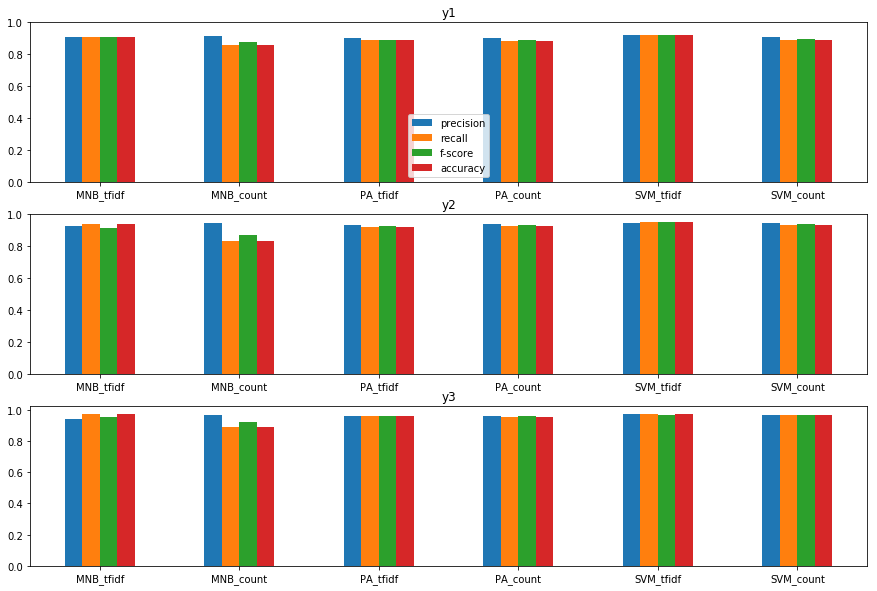

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1)
measures.iloc[0:6].plot(ax=axes[0],kind = 'bar', rot=0, title = 'y1', figsize=(15,10) , ylim = (0,1))
measures.iloc[6:12].plot(ax=axes[1],kind = 'bar', rot=0, title = 'y2', legend=False )
measures.iloc[12:18].plot(ax=axes[2],kind = 'bar', rot=0, title = 'y3' , legend=False)

### Introspect features

In [31]:
features_tfidf = pd.DataFrame() 
features_count = pd.DataFrame() 

y = [0,1,2]
for i in y:
   pd_tfidf = pd.DataFrame(tfidf[i], columns = ['weight', 'label']) 
   features_tfidf[i] = pd_tfidf['label']
   
for i in y:
   pd_count = pd.DataFrame(count[i], columns = ['weight', 'label']) 
   features_count[i] = pd_count['label']

features_tfidf.columns = ['y1', 'y2', 'y3']
features_count.columns = ['y1', 'y2', 'y3']

print('Features for count')
print(features_count)
print('Features for tfidf')
print(features_tfidf)

Features for count
            y1          y2          y3
0         risk         tax         tax
1          tax        risk        risk
2        group       group       group
3    financial  management  management
4   management   financial     control
5     business      change      policy
6        legal    business   committee
7       change     company   financial
8      company   authority    business
9      control         law       audit
10         law       audit  compliance
11       audit     control    internal
12  regulation       legal   authority
13      policy      policy     company
14  compliance          ha          ha
15   committee   committee       legal
16     country      result      report
17      result     country    strategy
18          ha      income      change
19   authority  compliance  department
Features for tfidf
            y1          y2              y3
0        riskb     taxable         taxable
1      taxable       riskb           riskb
2        group

## Gazetteer

In [32]:
train_df = pd.read_csv("private/train.csv")
test_df = pd.read_csv("private/test.csv")

In [33]:
df = pd.read_csv("private/data_clean.csv")
df.reset_index(drop=True, inplace=True)

### Helper functions

In [42]:
def gazetteer(text, count=1):
    """ Determine if paragraph can be considered as tax risk management.
    If c keywords are present in the text then it can be considered as tax risk management.

    Args:
        text: `string` text to analyze
        count: `int` the number of keywords to match

    Returns:
        `Boolean`
    """
    gazetteer = ["tax","risk","risks","group","financial",
             "management","changes","business","legal","company","authorities","compliance",
             "taxes","regulations","law","related","control","laws","committee"]
    
    # counter
    c = 0
    for g in gazetteer:
        if g in text:
            c += 1
    if c == count:
        return 1
    else:
        return 0

def random_guess(x):
    """Randomly guess 0 or 1.
    Args:
        x: dummy variable which is not used at all, but useful for passing to lambda function.
    Returns:
        `int`: 0 or 1
    """
    return np.random.randint(2)

def perform_check(test_df, func, v):
    """Perform check for the training and test datasets.
    
    Args:
        training_df: Pandas Dataframe of training examples.
        test_df: Pandas Dataframe of test examples.
        method_name: `string` method name to check.
        func: `function` to use.
        v: variable to analyze.
        
    Returns:
        Tuple of matches and accuracies for the training and test set as:
        (matches_train, accuracy_train, matches_test, accuracy_test)
    """

    # check for the test dataset
    pred = test_df['x'].apply(lambda x: func(x))
    accuracy =  metrics.accuracy_score(test_df[v], pred, normalize=True, sample_weight=None)
    prf = precision_recall_fscore_support(test_df[v], pred, average="weighted")
    return [accuracy] + list(prf)

In [50]:
def is_tax(text, count=1):
    """ Determine if paragraph can be considered as tax risk management.
    If c keywords are present in the text then it can be considered as tax risk management.

    Args:
        text: `string` text to analyze
        count: `int` the number of keywords to match

    Returns:
        `Boolean`
    """
    gazetteer = ["tax","risk","risks","group","financial",
             "management","changes","business","legal","company","authorities","compliance",
             "taxes","regulations","law","related","control","laws","committee"]
    
    # counter
    c = 0
    for g in gazetteer:
        if g in text:
            c += 1
    if c == count:
        return 1
    else:
        return 0

def random_guess(x):
    """Randomly guess 0 or 1.
    Args:
        x: dummy variable which is not used at all, but useful for passing to lambda function.
    Returns:
        `int`: 0 or 1
    """
    return np.random.randint(2)

def perform_check(train_df, test_df, method_name, func, v, verbose=True):
    """Perform check for the training and test datasets.
    
    Args:
        training_df: Pandas Dataframe of training examples.
        test_df: Pandas Dataframe of test examples.
        method_name: `string` method name to check.
        func: `function` to use.
        v: variable to analyze.
        verbose: `Boolean` to print verbose output.
        
    Returns:
        Tuple of matches and accuracies for the training and test set as:
        (matches_train, accuracy_train, matches_test, accuracy_test)
    """
    
    if verbose:
        print("Training set size: ", len(train_df))
        print("Test set size: ", len(test_df))
        print("-"*50)
        print("{} method for variable: {}".format(method_name, v))
    
    # check for the training dataset
    dummy_df = train_df['x'].apply(lambda x: func(x))
    matches_train = 0
    for i in range(len(dummy_df)):
        if dummy_df.loc[i] == train_df[v].loc[i]:
            matches_train += 1
    accuracy_train = matches_train/len(train_df)

    # check for the test dataset
    dummy_df = test_df['x'].apply(lambda x: func(x))
    matches_test = 0
    for i in range(len(dummy_df)):
        if dummy_df.loc[i] == test_df[v].loc[i]:
            matches_test += 1
    accuracy_test = matches_test/len(test_df)

    if verbose:
        print("Matches for training set: ", matches_train)
        print("Accuracy for training set: ", round(accuracy_train, 3))
        print("Matches for test set: ", matches_test)
        print("Accuracy for test set: ", round(accuracy_test, 3))
        print("-"*50)
        
    return (matches_train, accuracy_train, matches_test, accuracy_test)

def visualize(v, verbose=True):
    _, g_train_acc, _, g_test_acc = perform_check(train_df, test_df, 
                                                  "Gazetteer", is_tax, v, verbose=False)
    _, r_train_acc, _, r_test_acc = perform_check(train_df, test_df, 
                                                  "Random Guess", random_guess, v, verbose=False)
    
    x = ['Gazetteer: Train','Random Guess: Train','Gazetteer: Test', 'Random Guess: Test']
    y = [g_train_acc, r_train_acc, g_test_acc, r_test_acc]
    ax = sns.barplot(x, y)
    ax.set(xlabel='Methods', ylabel='Accuracy')
    plt.title('Gazetteer vs Random Guessing for variable: {}'.format(v))
    plt.xticks(rotation=10)

### Gazetteer vs Random Guess

#### y1

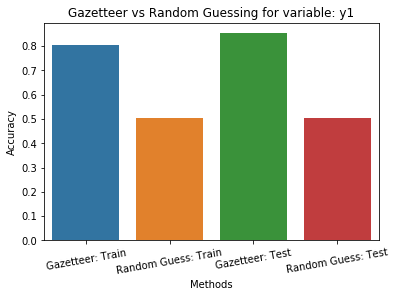

In [51]:
visualize('y1', verbose=False)

#### y2

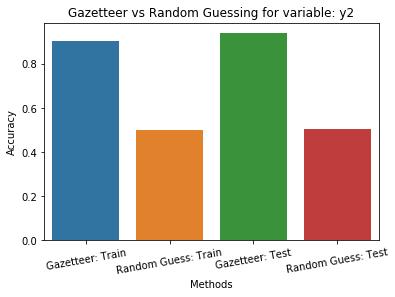

In [52]:
visualize('y2')

#### y3

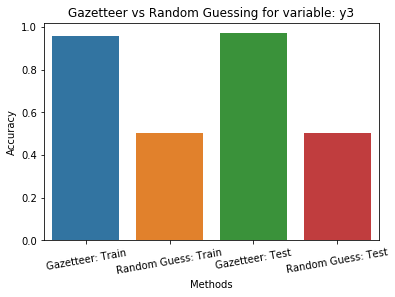

In [53]:
visualize('y3')

### Performance measures for plots

In [54]:
def perform_check(test_df, func, v):
    """Perform check for the training and test datasets.
    
    Args:
        training_df: Pandas Dataframe of training examples.
        test_df: Pandas Dataframe of test examples.
        method_name: `string` method name to check.
        func: `function` to use.
        v: variable to analyze.
        
    Returns:
        Tuple of matches and accuracies for the training and test set as:
        (matches_train, accuracy_train, matches_test, accuracy_test)
    """

    # check for the test dataset
    pred = test_df['x'].apply(lambda x: func(x))
    accuracy =  metrics.accuracy_score(test_df[v], pred, normalize=True, sample_weight=None)
    prf = precision_recall_fscore_support(test_df[v], pred, average="weighted")
    return [accuracy] + list(prf)

In [55]:
ACC_test_gazz = []
MCR_test_gazz = []

In [56]:
scores = perform_check(test_df, gazetteer, 'y1')
ACC_test_gazz.append(scores[0])
MCR_test_gazz += scores[1:]

In [57]:
scores = perform_check(test_df, gazetteer, 'y1')
ACC_test_gazz.append(scores[0])
MCR_test_gazz += scores[1:]

In [58]:
scores = perform_check(test_df, gazetteer, 'y1')
ACC_test_gazz.append(scores[0])
MCR_test_gazz += scores[1:]

In [59]:
MCR_test_gazz0 = [(MCR_test_gazz[0],MCR_test_gazz[1],MCR_test_gazz[2],MCR_test_gazz[3]),(MCR_test_gazz[4],MCR_test_gazz[5],MCR_test_gazz[6],MCR_test_gazz[7]),(MCR_test_gazz[8],MCR_test_gazz[9],MCR_test_gazz[10],MCR_test_gazz[11])]

## RCNN

In [60]:
# Embedding
max_features = 1000
maxlen = 500
embedding_size = 64

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 1

### Read data

In [61]:
train_df = pd.read_csv('private/train.csv')
test_df = pd.read_csv('private/test.csv')

In [62]:
def get_RCNN_train_test(y_i='y3'):
    tok = Tokenizer(num_words=max_features, split=' ')
    tok.fit_on_texts(train_df['x_sentences'].values)
    X_train = tok.texts_to_sequences(train_df['x_sentences'].values)
    Y_train = pd.get_dummies(train_df[y_i]).values

    X_test = tok.texts_to_sequences(test_df['x_sentences'].values)
    Y_test = pd.get_dummies(test_df[y_i]).values

    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    return X_train,Y_train,X_test,Y_test

### Build a model

In [63]:
def get_RCNN_model(X_train,Y_train,X_test,Y_test):
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, 
                        input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    print("Model summary: ")
    print(model.summary())

    print('Train...')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs)

    score, acc = model.evaluate(X_train, Y_train, batch_size=batch_size)
    print("Score on train set: ", score)
    print("Accuracy on train set: ", acc)

    score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
    print("Score on test set: ", score)
    print("Accuracy on test set: ", acc)
    Y_pred = model.predict(X_test)
    Y_pred = (Y_pred > 0.5).astype(int)
    return Y_pred

In [64]:
def get_RCNN_precrecf1acc(Y_test,Y_pred):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    # [0, 1] positive, i.e, tax risk exists
    # [1, 0] negative, no tax risk
    for i in range(len(Y_test)):
        # positive
        if np.argmax(Y_test[i]) == 1:
            # positive
            if np.argmax(Y_pred[i]) == 1:
                tp += 1
            # negative
            else:
                fn += 1
        # negative        
        else:
            # negative
            if np.argmax(Y_pred[i] == 0):
                tn +=1
            # positive
            else:
                fp += 1
    print("True positive: ", tp)
    print("False positive: ", fp)
    print("True negative: ", tn)
    print("False negative: ", fn)
    cm = [
        [tn, fp],
        [fn, tp]
    ]
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print("Precision: %.4lf"%precision)
    print("Recall: %.4lf"%recall)
    print("F1-score: %.4lf"%f1_score)
    print("Accuracy: %.4lf"%accuracy)
    return precision, recall, f1_score, accuracy

In [65]:
MCR_test_RCNN = []
ACC_test_RCNN = []
X_train,Y_train,X_test,Y_test = get_RCNN_train_test('y1')
Y_pred1 = get_RCNN_model(X_train,Y_train,X_test,Y_test)
precision, recall, f1_score, accuracy = get_RCNN_precrecf1acc(Y_test,Y_pred1)
MCR_test_RCNN.append((precision,recall,f1_score,None))
ACC_test_RCNN.append(accuracy)

Model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 64)           20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 142       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0    

In [66]:
X_train,Y_train,X_test,Y_test = get_RCNN_train_test('y2')
Y_pred2 = get_RCNN_model(X_train,Y_train,X_test,Y_test)
precision, recall, f1_score, accuracy = get_RCNN_precrecf1acc(Y_test,Y_pred2)
MCR_test_RCNN.append((precision,recall,f1_score,None))
ACC_test_RCNN.append(accuracy)

Model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 64)           20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 142       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0    

In [67]:
X_train,Y_train,X_test,Y_test = get_RCNN_train_test('y3')
Y_pred3 = get_RCNN_model(X_train,Y_train,X_test,Y_test)
precision, recall, f1_score, accuracy = get_RCNN_precrecf1acc(Y_test,Y_pred3)
MCR_test_RCNN.append((precision,recall,f1_score,None))
ACC_test_RCNN.append(accuracy)

Model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 496, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 142       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0    

In [68]:
def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix from metrics.confusion_matrix numpy.ndarray
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
        classes: list of class names
    """
    if len(classes) == 2:
        # the count of true negatives is C_{0,0}, 
        # false negatives is C_{1,0}, 
        # true positives is C_{1,1}, 
        # false positives is C_{0,1}.
        classes = [classes[0]+": (- class)", classes[1]+": (+ class)"]
        
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig = plt.figure()
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels())
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")

def get_scores(cm):
    """Return precision, recall, accuracy, f1-score from confusion matrix.
       the count of true negatives is cm[0,0]
       the count of false negatives is cm[1, 0]
       the count of true positives is cm[1, 1]
       the count of false positives is cm[0, 1]
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
    
    Returns:
        scores: dictionary of scores
    """
    tn, fp, fn, tp = cm.ravel()
    
    scores = {}
    scores['precision'] = tp/(tp + fp)
    scores['recall'] = tp/(tp + fn)
    scores['accuracy'] = (tp + tn)/(tp + tn + fp + fn)
    scores['f1'] = 2*scores['precision']*scores['recall']/(scores['precision'] + scores['recall'])
    
    return scores    

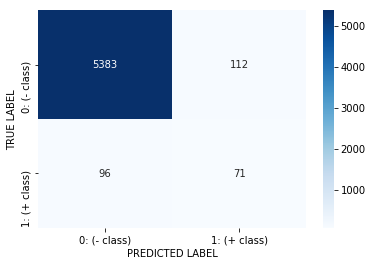

In [69]:
plot_confusion_matrix(cm, ['0', '1'])

## Evaluation

In [70]:
MCR = MCR_test[0:6]+MCR_test_gazz0[0:1]+MCR_test_RCNN[0:1]
MCR+= MCR_test[6:12]+MCR_test_gazz0[1:2]+MCR_test_RCNN[1:2]
MCR+= MCR_test[12:18]+MCR_test_gazz0[2:3]+MCR_test_RCNN[2:3]
#MCR
ACC = ACC_test[0:6]+ACC_test_gazz[0:1]+ACC_test_RCNN[0:1]
ACC+= ACC_test[6:12]+ACC_test_gazz[1:2]+ACC_test_RCNN[1:2]
ACC+= ACC_test[12:18]+ACC_test_gazz[2:3]+ACC_test_RCNN[2:3]
#ACC

In [71]:
measures = pd.DataFrame(MCR, 
                        columns=['precision', 'recall', 'f-score', 'support'], 
                        index = ['MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count', 'Gazetteer', 'RCNN',
                                 'MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count', 'Gazetteer', 'RCNN',
                                 'MNB_tfidf', 'MNB_count', 'PA_tfidf', 'PA_count', 'SVM_tfidf', 'SVM_count', 'Gazetteer', 'RCNN'])  
measures = measures.drop(['support'], axis=1)
se = pd.Series(ACC)
measures['accuracy'] = se.values

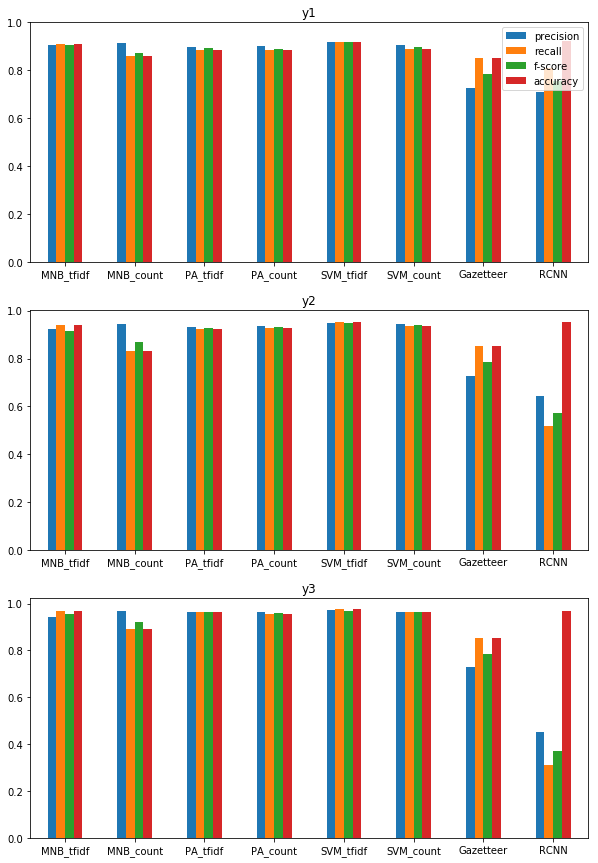

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=1)
measures.iloc[0:8].plot(ax=axes[0],kind = 'bar', rot=0, title = 'y1', figsize=(10,15), ylim = (0,1))
measures.iloc[8:16].plot(ax=axes[1],kind = 'bar', rot=0, title = 'y2', legend=False )
measures.iloc[16:24].plot(ax=axes[2],kind = 'bar', rot=0, title = 'y3' , legend=False)

# Clustering

Clustering is needed in terms of dummy y3, indicating that a paragraph discusses "tax risk management".
The concept of tax risk management is not easy to grasph therefore NLP is desperately needed. 
We aim to extract information from annual report with respect to which strategies companies undertake in order to avoid possible fines from not comply properly with tax risk laws.

## KMeans 

In [73]:
df = pd.read_csv("private/data_clean.csv")
dummy3_df = df[df['y3']==1].copy()
dummy3_df.reset_index(inplace=True)

### Preprocessing

In [74]:
# define stop words including punctuation
stop_words  = nltk.corpus.stopwords.words('english')
stop_words += [c for c in punctuation]

# create tfidf vectorizer
vectorizer = TfidfVectorizer(max_df=0.95,
                                  min_df=2,
                                  stop_words=stop_words,
                                  decode_error='ignore')
X = vectorizer.fit_transform(dummy3_df['x'])
words = vectorizer.get_feature_names()

### Choosing k

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

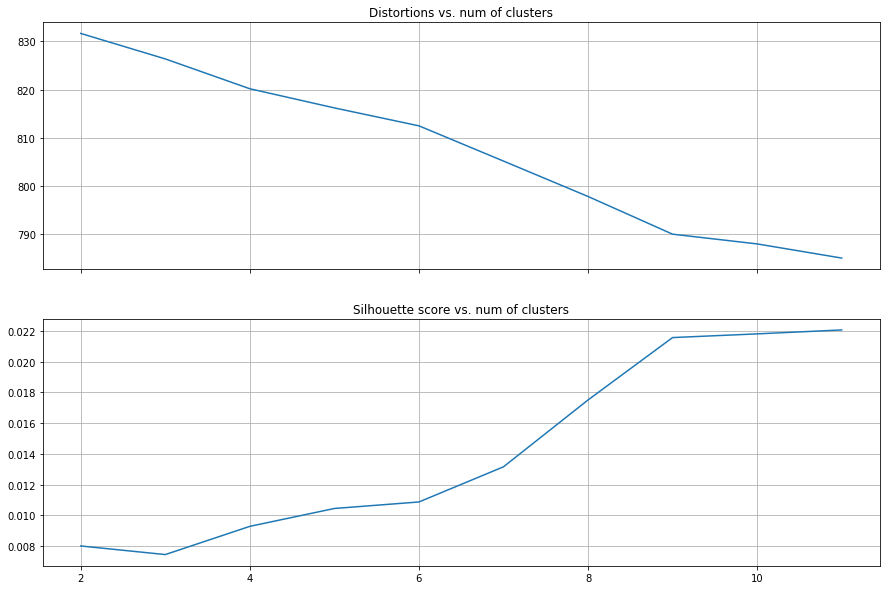

In [75]:
distortions = []
sil_scores = []
k_max = 12
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = KMeans(n_clusters=k, 
                          init='k-means++',
                          n_init=1, 
                          random_state=4222)
    kmeans_model.fit(X)
    sil_score = silhouette_score(X, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distortions.append(kmeans_model.inertia_)
 
# plot graphs to choose k
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distortions)
ax1.set_title('Distortions vs. num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs. num of clusters')
ax2.grid(True)

In [76]:
# based on observation we decided to choose k=7
num_clusters = 7
kmeans_model = KMeans(n_clusters=num_clusters, 
                      init='k-means++',
                      n_init=1, 
                      random_state=4222)

kmeans = kmeans_model.fit(X)
kmeans_clusters = kmeans.predict(X)
kmeans_distances = kmeans.transform(X)

### Important Words

In [77]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(num_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['topic_{0}'.format(i) for i in range(num_clusters)],
                           columns=['keywords_{0}'.format(i) for i in range(10)],
                           data=all_keywords)

keywords_df

,keywords_0,keywords_1,keywords_2,keywords_3,keywords_4,keywords_5,keywords_6,keywords_7,keywords_8,keywords_9
topic_0,system,control,management,including,company,body,related,corporate,policy,group
topic_1,group,management,policy,authority,provision,business,change,key,ha,pricing
topic_2,committee,group,audit,review,management,financial,strategy,reviewed,board,report
topic_3,page,financial,international,authority,relevant,note,group,statement,legal,disclosure
topic_4,group,income,liability,shareholder,business,open,law,value,management,cost
topic_5,control,internal,management,compliance,audit,group,system,policy,committee,board
topic_6,department,group,legal,subsidiary,regulation,accounting,control,nancial,ensures,management


### Plot Clusters

In [78]:
run = True
if run:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=4222, n_iter=500)
    tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
    kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
    kmeans_df['cluster'] = kmeans_clusters
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)
    kmeans_df['x_sentences'] = dummy3_df['x_sentences']
    kmeans_df['keywords'] = kmeans_df['cluster'].apply(lambda x: ", ".join(list(keywords_df.loc['topic_{}'.format(x)])))
    kmeans_df.to_csv("private/tsne_kmeans.csv", index=False, encoding="utf-8")
else:
    kmeans_df = pd.read_csv("private/tsne_kmeans.csv")
    kmeans_df['cluster'] = kmeans_df['cluster'].map(str)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 884 samples in 0.005s...
[t-SNE] Computed neighbors for 884 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 884 / 884
[t-SNE] Mean sigma: 0.016492
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.119350
[t-SNE] Error after 500 iterations: 0.648054


In [79]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

reset_output()
output_notebook()
plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                        x_axis_type=None, y_axis_type=None, min_border=1)

source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    x_sentences=kmeans_df['x_sentences'],
                                    keywords=kmeans_df['keywords'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"keywords": "@keywords", "cluster":"@cluster" }
show(plot_kmeans)

Loading BokehJS ...

## Topic Model 

In [85]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [86]:
#code from https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

documents2 = df['x'].tolist()
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents2)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents2)
tf_feature_names = tf_vectorizer.get_feature_names()

In [88]:
no_topics = 7 #number of topics to be clustered is determined manually

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

### Display the most predictive words for the topics

In [89]:
no_top_words = 10
print('Most predictive words for nmf')
display_topics(nmf, tfidf_feature_names, no_top_words)

print('Most predictive words for lda')
display_topics(lda, tf_feature_names, no_top_words)

Most predictive words for nmf
Topic 0:
liability current asset deferred total payable financial non reserve equity
Topic 1:
rate value discount cash flow pre use growth specific used
Topic 2:
group management financial audit committee control report internal business company
Topic 3:
income net loss profit operating expense asset impairment year loan
Topic 4:
provision charge note obligation litigation dispute december current statement restructuring
Topic 5:
capital cost average equity debt return ratio wacc premium weighted
Topic 6:
million euro eur december wa year compared result increase chf
Most predictive words for lda
Topic 0:
income million net loss year expense profit operating asset impairment
Topic 1:
group management financial audit business committee report control legal company
Topic 2:
rate value discount cash pre flow used asset based specific
Topic 3:
liability asset current deferred provision financial note total non equity
Topic 4:
rate capital equity market cost gr

### Visualize Results

#### Non negative matrix factorization with tfidf vectorizer

In [ ]:
panel = pyLDAvis.sklearn.prepare(nmf, tfidf, tfidf_vectorizer, mds='mmds')
panel
pyLDAvis.display(panel) 

#### LDA with count vecotirzer

In [91]:
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='mmds')
panel
pyLDAvis.display(panel) 

### Get topic index for each document

In [92]:
doc_topic = lda.transform(tf)

topic = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic.append(topic_most_pr)

se = pd.Series(topic) #assign list to dataframe
df['topic'] = se.values    

#vc = df.topic.value_counts() #topic 4 is the most important one! !!!this information is already included in the plot above
#vc.plot(kind='bar')
#print('The plot shows that topic', vc.argmax() + 1, 'is the topic with most documents assgined.')

### Print most informative paragraphs

In [95]:
doc_topic2= pd.DataFrame(data=doc_topic, columns = ('0','1','2','3','4', '5', '6'))
for column in doc_topic2:
    df[column]= doc_topic2[column] #assign topic probabilities to df
    
for column in doc_topic2: #print the paragraphs
    l0= df.nlargest(5, column)
    print('These are the' , len(l0) , 'most informative paragraphs for topic', column , '\n')
    for i in range(5):
        print(l0.x_sentences.iloc[i], '\n')

These are the 5 most informative paragraphs for topic 0 

 61 23,659 23,659 23,659 TOTAL 166,273 166,488 168,753 170,343 170,656 182,834 Consolidation adjustments Net book value 166,488 170,656   6.4. French retail banking \x96 Regional b anks   OPERATIONS AND CONTRIBUTION OF THE REGIONAL BANKS AND THEIR SUBSIDIARIES   (in millions of euros) 31/12/2007 31/12/2006  Adjusted net banking income  (1) 11,960 12,093 Operating expenses (7,005) (6,922) Gross operating income 4,955 5,171 Risk-related costs (984) (841) Operating income 3,971 4,330 Other items 71 Tax (1,339) (1,444) Adjusted aggregate net income of consolidated Regional Banks 2,639 2,887 Aggregate net income of subsidiaries of consolidated Regional Banks 124 104 Consolidation restatements and eliminations Consolidated net income of affiliates (100%) 2,763 2,992 Consolidated net income of affiliates (25%) 691 748 Consolidation restatements and eliminations (13) (12) Gain on increase in share of Regional Banks\x92 retained earnings